# Realce e Filtragem de Imagens

Vamos dar um "UP" nas nossas imagens!

Neste notebook, abordaremos como **melhorar** a qualidade visual ou destacar informações importantes. As técnicas se dividem em dois grandes grupos:
1.  **Espaciais:** Mexemos direto nos pixels (grelha).
2.  **Frequência:** Transformamos a imagem para um mundo de ondas (Fourier), filtramos e voltamos.

### Tópicos da Aula:
1.  **Transformação de Intensidade:** Gamma e Contraste.
2.  **Histogramas:** O "Censo Demográfico" da sua imagem.
3.  **Filtragem Espacial:** Gaussian Blur (Linear) vs Bilateral/NLM (Não-Linear).
4.  **Sharpening:** Como deixar a imagem mais nítida.
5.  **Domínio da Frequência (FFT):** Olhando a imagem como "som".



## 1) Setup e Utilitários
Bibliotecas padrão e funções auxiliares.

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 6)

def read_img(path, as_gray=False):
    if as_gray:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    else:
        img = cv2.imread(path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img is None:
        print(f"AVISO: Imagem não encontrada em '{path}'")
    return img

def show_grid(imgs, titles, cmap='gray', size=(15, 5)):
    fig, axes = plt.subplots(1, len(imgs), figsize=size)
    if len(imgs) == 1: axes = [axes]
    for ax, img, t in zip(axes, imgs, titles):
        if img.ndim == 2:
            ax.imshow(img, cmap=cmap)
        else:
            ax.imshow(img)
        ax.set_title(t)
        ax.axis('off')
    plt.show()

def plot_hist_cdf(img, title="Histograma & CDF"):
    plt.figure(figsize=(6,3))
    hist, bins = np.histogram(img.flatten(), 256, [0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()
    plt.plot(cdf_normalized, color = 'b')
    plt.hist(img.flatten(), 256, [0,256], color = 'r')
    plt.legend(('cdf','histogram'), loc = 'upper left')
    plt.title(title)
    plt.show()

In [9]:
# Carregando imagens
img_lena_gray = read_img('images/imgLena.jpg', as_gray=True)
noisy_lena = read_img('images/noisyLena.png', as_gray=True)
noisy_circuit = read_img('images/noisyCircuit.png', as_gray=True)
border_parking = read_img('images/borderParking.png', as_gray=True)

## 2) Transformações de Intensidade e Correção Gamma

A correção Gamma é crucial pois a resposta do olho humano (e de monitores) não é linear.

**Fórmula:**
$$ s = c \cdot r^\gamma $$

- $\gamma < 1$: Clareia imagens escuras (expande tons escuros).
- $\gamma > 1$: Escurece imagens claras (expande tons claros).

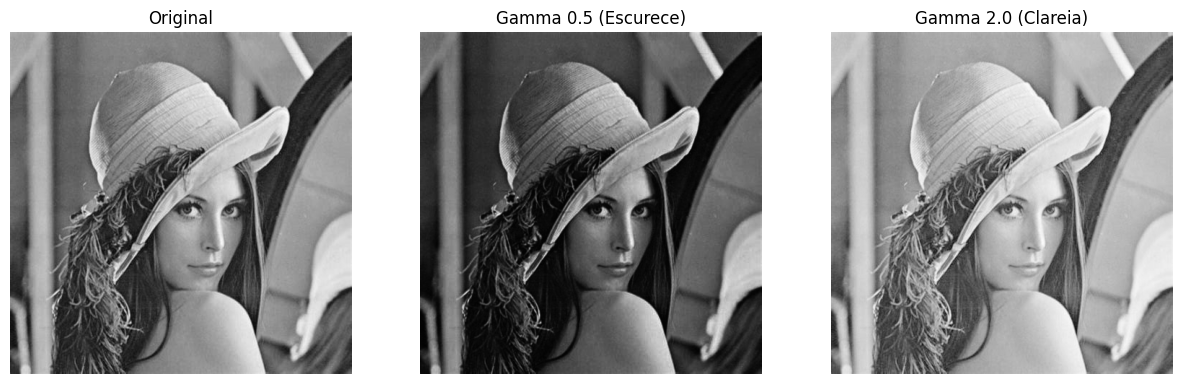

In [11]:
def gamma_correction(img, gamma=1.0):
    # Construir tabela de lookup (LUT) para velocidade
    # s = 255 * (r/255)^gamma
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(img, table)

gamma_05 = gamma_correction(img_lena_gray, 0.5) # Clarear
gamma_20 = gamma_correction(img_lena_gray, 2.0) # Escurecer

show_grid([img_lena_gray, gamma_05, gamma_20], 
          ["Original", "Gamma 0.5 (Escurece)", "Gamma 2.0 (Clareia)"])

## 3) Histogramas: Equalização Global vs CLAHE

O Histograma é o Censo Demográfico.
Ele conta: "Quantos pixels têm valor 0? Quantos têm valor 100? Quantos têm 255?"

**Equalização de Histograma** é como "socialismo/reforma agrária dos pixels": Pegamos regiões onde há muitos pixels acumulados (pouco contraste) e espalhamos eles para ocupar toda a faixa possível (0-255).

> **CLAHE:** Equalização Adaptativa Limitada. Em vez de equalizar a imagem toda de uma vez (o que pode explodir ruídos), fazemos isso em pequenos bloquinhos (tiles).



C:\Users\antonio.fontenele\AppData\Local\Temp\ipykernel_57904\5655629.py:36: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  plt.hist(img.flatten(), 256, [0,256], color = 'r')


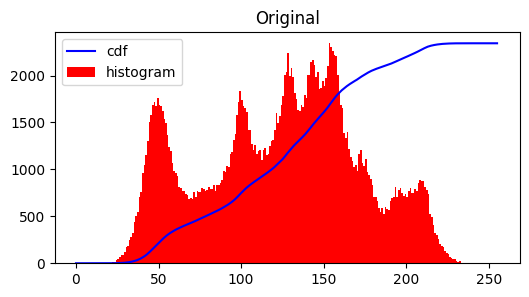

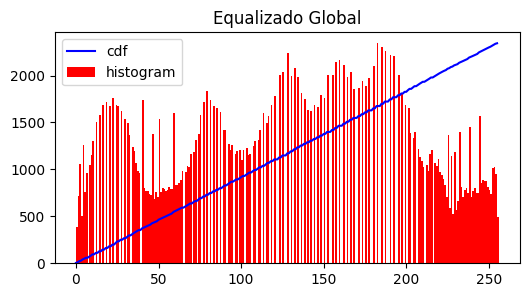

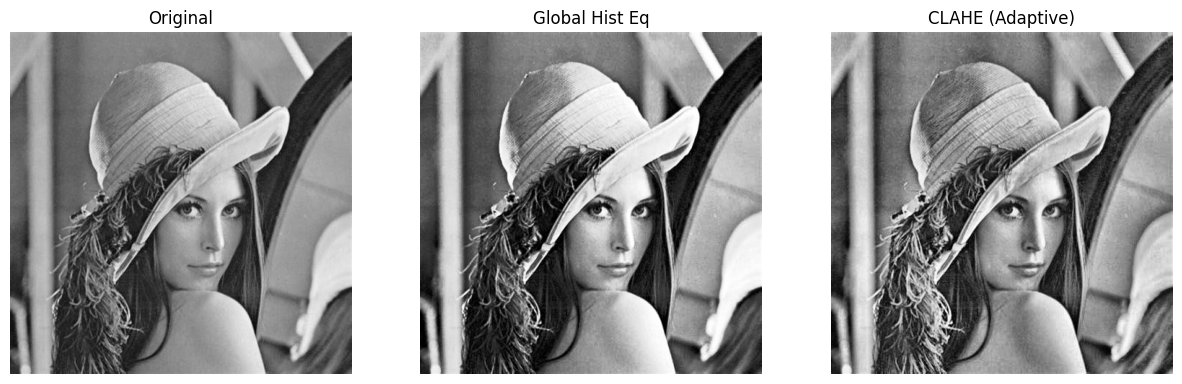

In [4]:
eq_global = cv2.equalizeHist(img_lena_gray)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
res_clahe = clahe.apply(img_lena_gray)

plot_hist_cdf(img_lena_gray, "Original")
plot_hist_cdf(eq_global, "Equalizado Global")   
    
show_grid([img_lena_gray, eq_global, res_clahe], 
          ["Original", "Global Hist Eq", "CLAHE (Adaptive)"])

## 4) Filtragem Espacial: Denoising Avançado

**Filtros Lineares (ex: Gaussian Blur, Média):** Eles suavizam tudo. Ruído e Bordas. O resultado é uma imagem "embaçada".
**Filtros Não-Lineares (ex: Mediana, Bilateral):** São mais inteligentes.
- **Mediana:** Ótimo para ruído "Sal e Pimenta".
- **Bilateral:** Faz uma média ponderada não só pela distância (gaussiana espacial), mas também pela semelhança de cor (gaussiana de intensidade). Ou seja: **"Só misturo com meu vizinho se ele for parecido comigo".** Isso preserva bordas!



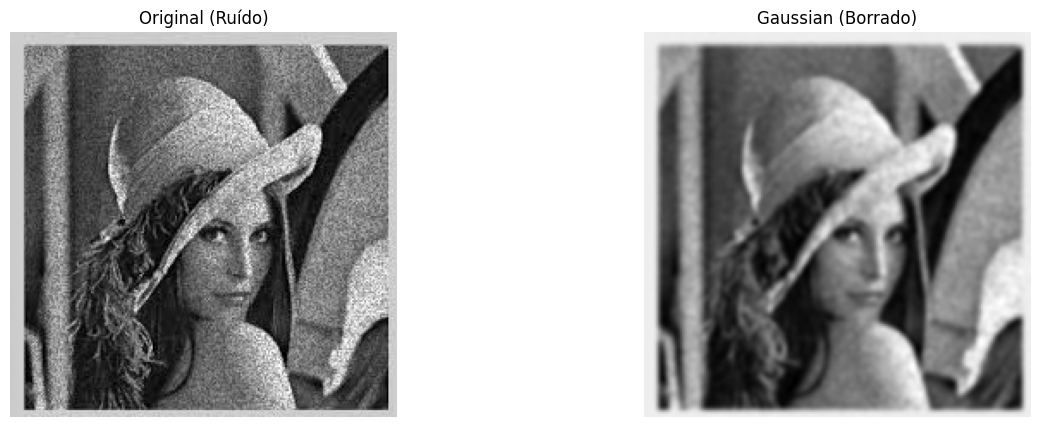

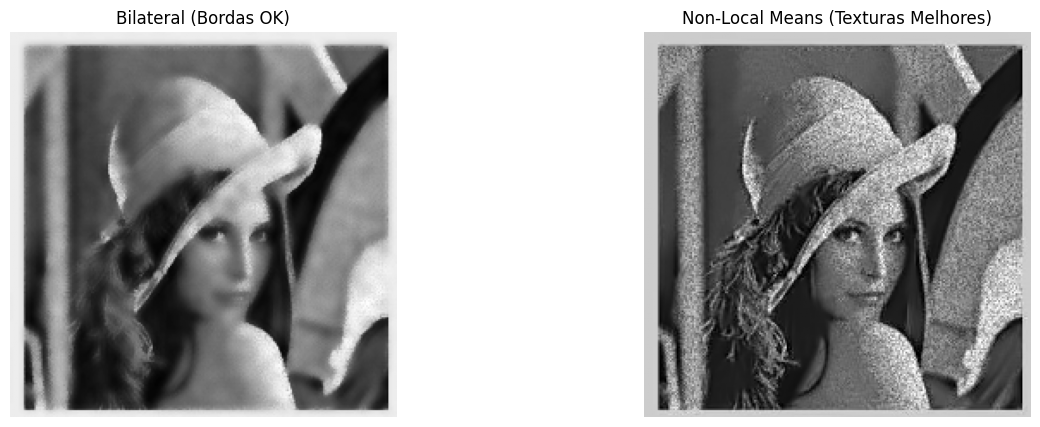

In [12]:
# 1. Gaussian
gauss = cv2.GaussianBlur(noisy_lena, (7,7), 0)

# 2. Bilateral (Preserva bordas, mas lento)
# d=9, sigmaColor=75, sigmaSpace=75
bilateral = cv2.bilateralFilter(noisy_lena, 9, 75, 75)

# 3. Non-Local Means (Estado da arte clássico)
# h: força do filtro (10 é bom, 30 é forte)
# templateWindowSize: 7 (tamanho do patch comparado)
# searchWindowSize: 21 (onde procurar patches similares)
nlm = cv2.fastNlMeansDenoising(noisy_lena, None, h=10, templateWindowSize=7, searchWindowSize=21)

show_grid([noisy_lena, gauss], ["Original (Ruído)", "Gaussian (Borrado)"])
show_grid([bilateral, nlm], ["Bilateral (Bordas OK)", "Non-Local Means (Texturas Melhores)"])

> **Nota:** Compare a textura do chapéu ou do cabelo da Lena. O NLM geralmente preserva detalhes finos melhor que o Bilateral.

### Modern Insight: Guided Filter
Uma alternativa moderna ao Bilateral é o **Guided Filter** (He et al., 2010). Ele é **O(N)** (tempo linear, independe do tamanho do kernel) e não sofre de "gradient reversal artifacts". É muito usado em HDR e Dehazing.

## 5) Realce (Sharpening)

**Intuição:** Como deixar mais nítido?
Paradoxalmente, para realçar bordas, usamos o *blur*.
A fórmula do **Unsharp Masking** é:
$$ \text{Imagem Nítida} = \text{Original} + (\text{Original} - \text{Borrada}) $$
A parte $(\text{Original} - \text{Borrada})$ contém apenas as "altas frequências" (detalhes/bordas). Somamos isso de volta à original para reforçar esses detalhes.



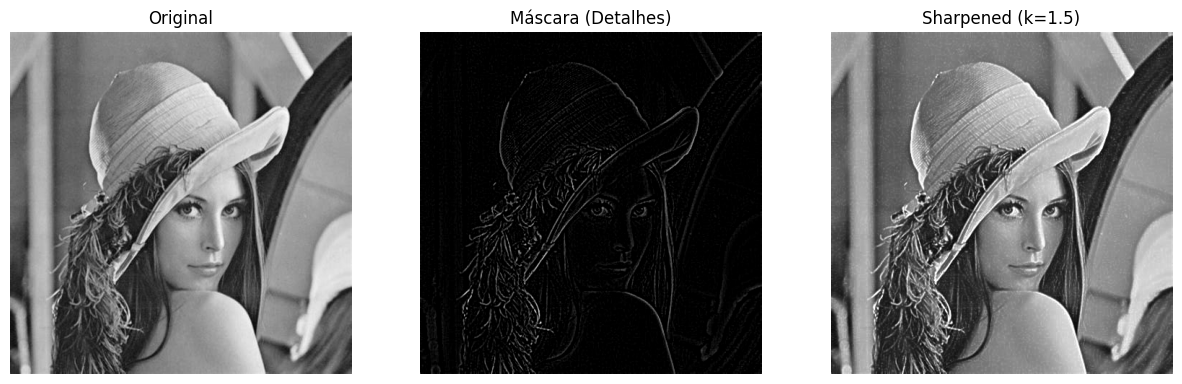

In [6]:
img = img_lena_gray

# 1. Criar versão borrada
blurred = cv2.GaussianBlur(img, (9,9), 2.0)

# 2. Calcular a máscara (detalhes de alta frequência)
mask = cv2.addWeighted(img, 1.0, blurred, -1.0, 0)

# 3. Adicionar máscara de volta (k=1.5)
k = 1.5
sharp = cv2.addWeighted(img, 1.0, mask, k, 0)

show_grid([img, mask, sharp], ["Original", "Máscara (Detalhes)", f"Sharpened (k={k})"])

## 6) Domínio da Frequência (FFT)

Imagem também é onda!
Assim como um som pode ser decomposto em graves e agudos, uma imagem pode ser decomposta em:
- **Baixas Frequências:** Regiões lisas, céu, pele suave (mudanças lentas de cor).
- **Altas Frequências:** Bordas, texturas, ruído, cabelo (mudanças rápidas de cor).

A **Transformada de Fourier (FFT)** nos leva para esse mundo. Lá, podemos apagar as altas frequências (Low Pass Filter) para suavizar, ou apagar as baixas (High Pass Filter) para detectar bordas.



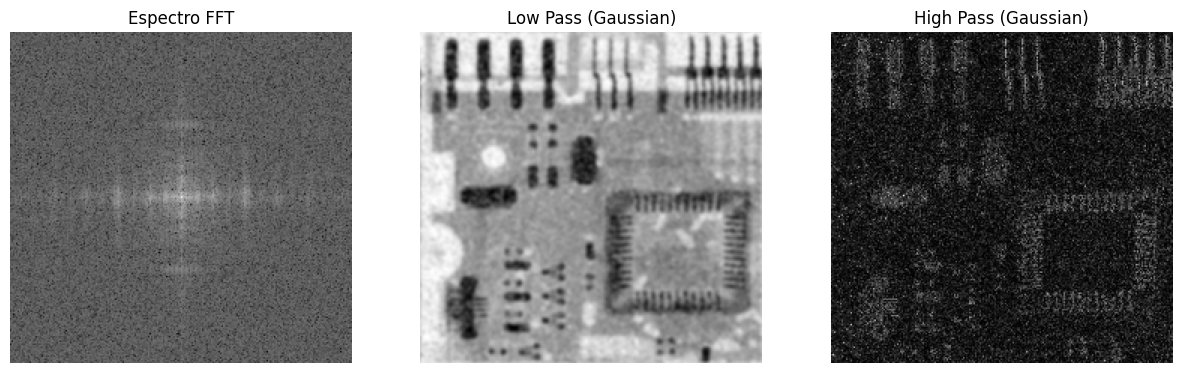

In [7]:
def fft_filter(img, radius=30, type='lowpass'):
    rows, cols = img.shape
    crow, ccol = rows//2, cols//2
    
    # FFT
    dft = np.fft.fft2(img)
    dft_shift = np.fft.fftshift(dft)
    
    # Máscara Gaussiana (para evitar ringing do filtro Ideal)
    x = np.arange(cols)
    y = np.arange(rows)
    X, Y = np.meshgrid(x, y)
    dist_sq = (X - ccol)**2 + (Y - crow)**2
    
    # H(u,v) = exp(-D^2 / 2D0^2)
    sigma = radius
    H = np.exp(-dist_sq / (2*sigma**2))
    
    if type == 'highpass':
        H = 1 - H
        
    # Filtragem
    fshift = dft_shift * H
    
    # Inversa
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    
    return img_back, 20*np.log(np.abs(dft_shift)+1)

lp_res, spectrum = fft_filter(noisy_circuit, 30, 'lowpass')
hp_res, _ = fft_filter(noisy_circuit, 30, 'highpass')

show_grid([spectrum, lp_res, hp_res], 
          ["Espectro FFT", "Low Pass (Gaussian)", "High Pass (Gaussian)"])

## 7) Fronteiras Modernas: Deep Learning

Hoje, métodos como **DnCNN** (Denoising CNN) ou **U-Net** superam o NLM e Bilateral ao "aprender" como o ruído se parece.

Enquanto filtros clássicos usam matemática fixa ($G_s \cdot G_r$), uma CNN aprende milhares de filtros convolucionais $W_i$ através de dados de treinamento:
$$ \hat{I} = f_{CNN}(I_{noisy}; \theta) $$

Apesar disso, **NLM** e **Bilateral** continuam sendo fundamentais quando não temos dados de treino ou capacidade computacional (GPU) disponível.